## Analyzing Media Sources and Content in Facebook Groups

Extracting which news domains are most prevalent within a community of partisan Facebook groups provides insight into what information sources are influencing opinion in that given community. Identifying which articles are most frequently shared provides an understanding of what narratives are gaining traction in that community. 

In cases where we know which media outlets are non-credible information sources that generate false and misleading content, we can assess the prevalence of potential disinformation in a given community. By comparing articles shared from credible and junk news sources in a community, we can assess the degree to which credible and junk news articles overlap and the extent to which public opinion may be distorted by false and misleading narratives. 

**Where they exist, lists or databases of websites that are known to spread false or misleading information are useful for flagging content that may warrant particular scrutiny. Examples of lists of known non-credible sources include the Oxford Internet Institute’s “Junk News Aggregator”, FactCheck.org’s “Misinformation Directory”, and Media Monitoring Africa’s “KnowNews” tool. An example of how such lists have been applied to social media: The University of Michigan Center for Social Media Responsibility's "Iffy Quotient" project tracks the spread of information from non-credible news sources classified by NewsGuard and Media Bias/Fact Check: https://csmr.umich.edu/projects/iffy-quotient/.*  

In this example, we will grab 10,000 posts from the pro-Georgia Republican community of 16 groups we identified in the previous notebook. We will identify which news domains are most prevalent, which domains are known to spread false and misleading information, and which articles from credible and non-credible sources are gaining traction. To identify non-credible information sources, we will reference sites identifed by FactCheck.org and NewsGuard as domains known to spread false and misleading information.

First, we'll import packages needed for script, add API token from the CrowdTangle dashboard you created, and add a database connection to store posts data we collect from sample groups

In [16]:
import requests
import json
import pandas as pd
import numpy as np
import collections
from datetime import datetime, timedelta 
import time
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import pyodbc 
from sqlalchemy import create_engine

#crowdtangle token:
token = 'your_token'

#database connection:
connection_string = 'your_connection_string'
engine = create_engine(connection_string, encoding='utf8')
db = engine.connect()

We create a 'get_lists' function (CrowdTangle Lists API wrapper) to use to access all lists in the dashboard that have been created. Then we will grab the id of the list of the pro-Georgia Republican groups community we identified in the last notebook.   

In [2]:
def get_list_info():
    ctapi_list = 'https://api.crowdtangle.com/lists?token='
    api_url = format(f'{ctapi_list}{token}')
    response = requests.get(api_url)
    if response.status_code == 200:
        return json.loads(response.content.decode('utf-8'))
    else:
        return None
    
list_info = get_list_info()
list_info['result']['lists']

[{'id': 1490375, 'title': 'Republican Snowball Pages', 'type': 'LIST'},
 {'id': 1490376, 'title': 'Republican Snowball Groups', 'type': 'LIST'},
 {'id': 1490497, 'title': 'GA Republican Groups', 'type': 'LIST'}]

The list id for the pro-Georgia Republican Groups community is '1490497'.

We create a 'get_posts' function (CrowdTangle Posts API wrapper) to get up to last 10,000 posts from these groups during date range provided.

We'll set a custom date range even though we will only get the last 10,000 posts available - we'll use a two-week window during which to retrieve posts.

In [3]:
idx = '1490497' 
start = '2020-12-14' #Dec 14 2020
end = '2020-12-28' #Dec 28 2020
allposts = []
def get_posts():
    ctapi_posts = 'https://api.crowdtangle.com/posts?token='
    start_date = '&startDate='
    end_date = '&endDate=' 
    listids = '&listIds='
    count = '&count='
    n = '100'
    offset = '&offset='
    sortBy = '&sortBy='
    sort = 'total_interactions'
    api_url = format(f'{ctapi_posts}{token}{listids}{idx}{start_date}{start}{end_date}{end}{count}{n}{sortBy}{sort}{offset}')
    for o in range(0,10000,100):
        api_call = api_url + str(o)
        response = requests.get(api_call).json()
        time.sleep(10)
        allposts.append(response)
        print(api_call)
        
def posts_toframe(allposts):
    temp = pd.DataFrame(allposts)
    temp = pd.concat([temp.drop(['result'], axis=1), temp['result'].apply(pd.Series)], axis=1)
    temp = temp.explode('posts')
    temp = pd.concat([temp.drop(['posts'], axis=1), temp['posts'].apply(pd.Series)], axis=1)
    temp = temp.rename(columns={"subscriberCount": "initialSubscriberCount", "id": "initialId", "platformId": "initialPlatformId", "platform": "initialPlatform"})
#expand account data into individual columns
    temp = pd.concat([temp.drop(['account'], axis=1), temp['account'].apply(pd.Series)], axis=1)
#expand statistics data into invidivual columns
    temp = pd.concat([temp.drop(['statistics'], axis=1), temp['statistics'].apply(pd.Series)], axis=1)
    temp = pd.concat([temp.drop(['actual'], axis=1), temp['actual'].apply(pd.Series)], axis=1)
    temp['date'] = pd.to_datetime(temp.date)
    temp['updated'] = pd.to_datetime(temp.updated)
    temp['id'] = temp['id'].astype(object)
    temp = temp.drop(['status', 'pagination'], axis=1)
    return temp

Now we'll run the get_posts function to retrieve up to 10,000 posts. Note: to address API rate limits, the get_posts function takes 15+ minutes to run (now's a good time to brew another pot of coffee).

In [47]:
get_posts()

We'll convert the data we just obtained to a dataframe.

In [8]:
ga_rep_group_posts = posts_toframe(allposts)

From this data, we'll select only the posts that contain a domain and then we'll remove domains that are not (technically) news sources (youtube and twitter)

In [10]:
domains = ga_rep_group_posts[ga_rep_group_posts['caption'].notnull()]
domains = domains.loc[~domains['caption'].isin(['youtube.com', 'twitter.com'])]

Let's take a quick peek at the number of posts that contain news links

In [12]:
len(domains)

1029

To determine which of these sources are non-credible information sources ("junk news"), we'll import a list of 191 sources known for disseminating false and misleading information from two sources: NewsGuard and FactCheck.

* NewsGuard rates the credibility of media outlets and assigns a 'red' rating to a source that "generally fails to meet basic standards of credibility and transparency." https://www.newsguardtech.com/ratings/rating-process-criteria/.
* FactCheck published a 'misinformation directory' in 2018 containing a list of websites that have posted deceptive content: https://www.factcheck.org/2017/07/websites-post-fake-satirical-stories/

We import the list here as "junkdomains" (and convert the domains to lowercase).

In [14]:
junkdomains = pd.read_csv("junknews.csv", encoding='unicode_escape')
junkdomains["junkdomain"] = junkdomains["junkdomain"].str.lower()

We label all the domains in data as either 'junk' or 'not junk' based on whether they appear in the our junkdomains list -- then we take a peek at how many links are from junk news sources.

In [28]:
domains['junk'] = np.where(domains['caption'].isin(junkdomains['junkdomain']), "Junk", "Not Junk")
domains.groupby(['junk']).size()

junk
Junk        246
Not Junk    783
dtype: int64

It appears that nearly 1 in 4 links that have been shared are from sources known to spread false and misleading information. 

We sort the domains by how often they appear and whether they are labeled as 'junk' or 'not junk' in the data. Then we grab the 20 domains that appear most frequently in the data.

In [29]:
domains_junk_sort = domains.groupby(['caption', 'junk']).size().to_frame().reset_index().sort_values(by=0, ascending=False)
domains_junk_sort = domains_junk_sort.rename(columns={0: 'shares'}).reset_index(drop=True)
domains_junk_top20 = domains_junk_sort.nlargest(20, 'shares')

Now we plot a bar graph that shows which domains most frequently appear in the data. Sources that are labelled 'junk' appear in red, sources that are 'not junk' appear in blue.  

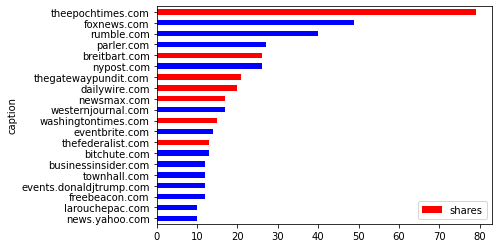

In [30]:
domains_junk_top20.plot.barh(x='caption', y='shares', color=domains_junk_top20.junk.map({'Junk': 'r', 'Not Junk': 'b'})).invert_yaxis()

Based on the graph, content from The Epoch Times, which has been described as 'a vehicle for pro-Trump conspiracy theories'*, appears most frequently in the data by far. Meanwhile, content from the conservative social networking sites Parler and Rumble (and to  a lesser extent, BitChute) are among the most prominent sources of information. Content from Fox News - a traditionally dominant source of information in Republican media - is also prominent along with junk news sources such as Breitbart, Gateway Pundit, Daily Wire, and Newsmax.

**https://www.niemanlab.org/2020/10/what-is-the-epoch-times-a-vehicle-for-pro-trump-conspiracy-theories-and-the-culmination-of-all-that-facebook-has-encouraged/*

Before we take a look at what specific content from these sources are gaining traction, we'll create a new dataset without Parler, Rumble, BitChute and Eventbrite -- since they they are not technically news sites. 

In [31]:
domains_sub = domains.loc[~domains['caption'].isin(['parler.com', 'rumble.com', 'eventbrite.com', 'bitchute.com'])]

With these sites now removed, we'll calculate what percentage of content comes from junk news sources.

In [36]:
(len(domains_sub[domains_sub['junk'] == 'Junk']) / len(domains_sub))*100

26.31016042780749

26.3% of all links come from sources that are known to share false and misleading information! 

Modify the code to group and sort domains by the number of times they appear in the community groups to include whether they are 'junk'. 

To get a sense of the content from these sources that is circulating in this community, we can extract the article headlines ('Title") of the sources that have potentially been seen by the most users. 
<br/>
<br/>
As a first step, we'll remove any rows where the title data is missing. 

In [37]:
articles = domains_sub[domains_sub['title'].notnull()]

Then we'll group the articles by domain ('caption') and headline ('title') and sort the articles according to potential reach ('subscriberCount') in the community. NB: in a larger dataset, you might opt to sort the articles by  the number of shares as a means of gauging popularity. 

In [38]:
articles_sort = articles[['caption', 'title', 'subscriberCount','junk']]
articles_sort = articles_sort.groupby(['caption', 'title', 'junk']).sum().reset_index().sort_values(by='subscriberCount', ascending=False)

Now we grab and plot the 20 articles from credible news sources that have the largest reach within community groups.

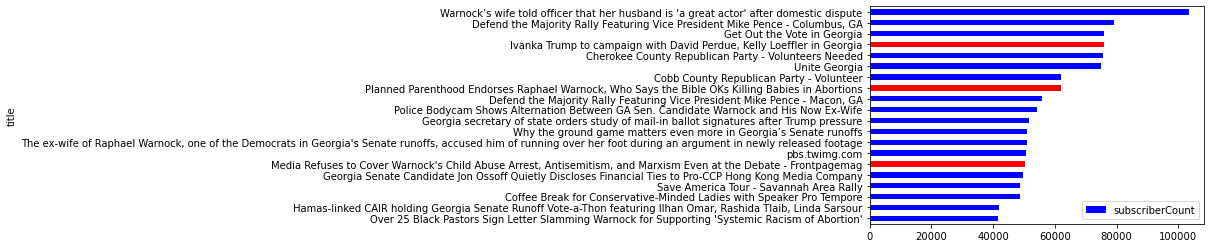

In [41]:
articles_top20 = articles_sort.nlargest(20, 'subscriberCount')
articles_top20.plot.barh(x='title', y='subscriberCount', color=articles_top20.junk.map({'Junk': 'r', 'Not Junk': 'b'})).invert_yaxis()

The majority of links are related to GOTV efforts and rallies however several articles focus on attacking Democratic Senate Candidate Raphael Warnock, including multiple articles that  reference a domestic violence incident and a couple that attack his pro-choice stance (and Christian faith). 

To drill down further into some of the content attacking Raphael Warnock, we'll find all headlines that mention 'Warnock'

In [42]:
warnock_articles = articles_sort[articles_sort['title'].str.contains("Warnock")]

We sort and plot the top 20 articles that mention Democratic Senate Candidate Raphael Warnock

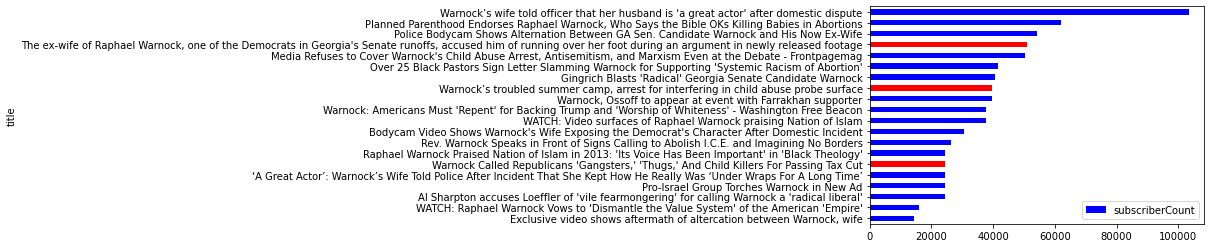

In [44]:
warnock_articles_top20 = warnock_articles.nlargest(20, 'subscriberCount')
warnock_articles_top20.plot.barh(x='title', y='subscriberCount', color=articles_top20.junk.map({'Junk': 'r', 'Not Junk': 'b'})).invert_yaxis()

Based on the graph, several narrative attack themes can be seen, notably from non-junk sources and reinforced by junk news sources:

* Warnock is a domestic abuser and child abuser
* Warnock's political views are inconsistent with Christian beliefs
* Warnock embraces radical Islamist views
* Warnock is a radical socialist 

Finally, let's take a look at content from just the junk news sources. 

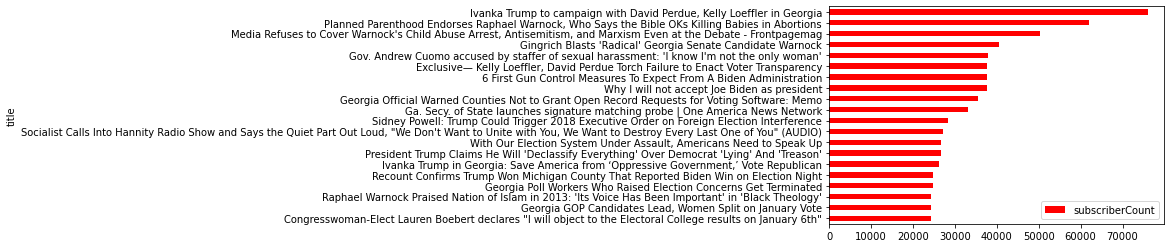

In [46]:
junk_articles = articles_sort[articles_sort['junk'] == 'Junk']
junk_articles_top20 = junk_articles.nlargest(20, 'subscriberCount')
junk_articles_top20.plot.barh(x='title', y='subscriberCount', color='r').invert_yaxis()

Junk news content echoes the aforementioned attacks on Warnock, but the most prominent theme of junk news relates to baseless allegations that the 2020 presidential election was marred by massive voter fraud. Broad attacks on national Democratic Party leader and its supposed radical agenda are lesser prominent themes.

Finally, we'll create a couple of wordclouds to do a quick comparison of key topics in news articles - both from non-junk news sources and junk news sources. 

Before creating our wordclouds, we'll remove some words that don't add much context, e.g. "Georgia", "Breaking", "Report", etc.

In [73]:
stop_words.update(['Georgia', 'State', 'County', 'Breaking', 'Video', 'Report', 'New', 'Say', 'Says', 'GA'])

First we'll create a word cloud from the article tites of non-junk news sources.

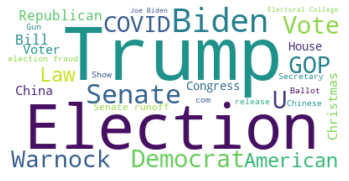

In [74]:
non_junk_articles = articles_sort[articles_sort['junk'] == 'Not Junk']
non_junk_text = " ".join(word for word in non_junk_articles['title'])
wordcloud = WordCloud(stopwords=stop_words, background_color="white", max_words=30).generate(non_junk_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Trump and Biden feature very prominently in non-junk news articles. Some other keywords that appear frequently are Warnock, China, election fraud, and COVID. 

We'll compare this with content from junk news articles. 

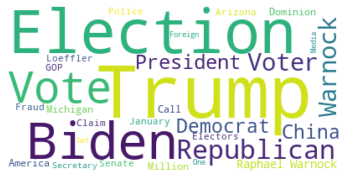

In [75]:
junk_text = " ".join(word for word in junk_articles['title'])
wordcloud = WordCloud(stopwords=stop_words, background_color="white", max_words=30).generate(junk_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Similar to the word cloud of non-junk news articles, Trump and Biden dominate the headlines. Warnock, China  and fraud are also mentioned quite a bit and some other keywords emerge, including Dominion, Michigan and Arizona -- presumably in reference to claims of voter fraud during the 2020 Presidential election.  

In the next notebook, we'll extract the messages being posted in these 16 pro-Gerogia Republican groups and extract topics that are most prominent in discussion. 